In [1]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')
import math
# Qiskit packages
# from qiskit_textbook.tools import vector2latex
from qiskit.quantum_info import Statevector
from qiskit.transpiler.passes import Unroller
from qiskit import BasicAer, QuantumCircuit, ClassicalRegister, QuantumRegister, IBMQ, Aer, assemble, transpile, execute
from qiskit.quantum_info import Pauli, Statevector
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.circuit.library import TwoLocal
# import qiskit.providers.aer as Some
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.algorithms.optimizers import SPSA
# for mocks
import qiskit.test.mock as mok
from qiskit.test.mock import FakeMelbourne as Mback


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from QPSA import (
    initialize_s,
    initialize_Gq,
    diffuser,
    partial_diffuser,
    oracle,
    grover_operator,
    local_grover_operator,
    design_grover_circuit,
    design_partial_grover_circuit,
    classic_grover_stats,
    QPSA_stats,
    design_and_test_two_stage,
    multi_controlled_toffoli
)
from RunTests import ThreeQubitCases, OtherCases
# , test_experiment_expected_depth, test_experiment_actual_probability
from NoiseModels import NoiseModels
import RunTests as testies
import NoiseModels as noisies

In [4]:
# Creating simulators with different noise models
device_backend = Mback()
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
basis_gates = NoiseModels(1).initialize_thermal_noise().basis_gates
testers = []
noise_consts = list([x/10 for x in range(6, 20)])
for i in noise_consts:
    noise_constant = i
    NM = NoiseModels(noise_constant)
    noise_model = NM.initialize_thermal_noise()
    backend = QasmSimulator(method='density_matrix',
                                noise_model=noise_model)
    execution_params = (coupling_map, basis_gates, noise_model)
    testers+=[OtherCases(backend, execution_params)]

        
Len = len(testers)
    
def test_experiment(experiment):
    results = []
    for i in range(Len):
        print("NOISE CONSTANT:", noise_consts[i])
        res = experiment(testers[i])
        results += [res]
    return results    

def test_experiment_expected_depth(experiment):
    results = []
    for i in range(Len):
        print("NOISE CONSTANT:", noise_consts[i])
        res = experiment(testers[i])
        results += [res[5]]
    return results


def test_experiment_actual_probability(experiment):
    results = []
    for i in range(Len):
        print("NOISE CONSTANT:", noise_consts[i])
        res = experiment(testers[i])
        results += [res[2]]
    return results

# tests on 6 qubits
ress_D6_1M6 = test_experiment_expected_depth((lambda test_class: testies._D6_iM6(test_class, 1)))
ress_D6_2M6 = test_experiment_expected_depth((lambda test_class: testies._D6_iM6(test_class, 2)))
ress_D4_1M6 = test_experiment_expected_depth((lambda test_class: testies._D4_iM6(test_class, 1)))
ress_D4_2M6 = test_experiment_expected_depth((lambda test_class: testies._D4_iM6(test_class, 2)))
ress_D4_3M6 = test_experiment_expected_depth((lambda test_class: testies._D4_iM6(test_class, 3)))
ress_D4_1M2_D4_1M4 = test_experiment_expected_depth((lambda test_class: testies._D4_i1M2_D4_i2M4(test_class, 1, 1)))
ress_D4_2M2_D4_2M4 = test_experiment_expected_depth((lambda test_class: testies._D4_i1M2_D4_i2M4(test_class, 2, 2)))

NOISE CONSTANT: 0.6
Test D6_1M6: __________________
NOISE CONSTANT: 0.7
Test D6_1M6: __________________
NOISE CONSTANT: 0.8
Test D6_1M6: __________________
NOISE CONSTANT: 0.9
Test D6_1M6: __________________
NOISE CONSTANT: 1.0
Test D6_1M6: __________________
NOISE CONSTANT: 1.1
Test D6_1M6: __________________
NOISE CONSTANT: 1.2
Test D6_1M6: __________________
NOISE CONSTANT: 1.3
Test D6_1M6: __________________
NOISE CONSTANT: 1.4
Test D6_1M6: __________________
NOISE CONSTANT: 1.5
Test D6_1M6: __________________
NOISE CONSTANT: 1.6
Test D6_1M6: __________________
NOISE CONSTANT: 1.7
Test D6_1M6: __________________
NOISE CONSTANT: 1.8
Test D6_1M6: __________________
NOISE CONSTANT: 1.9
Test D6_1M6: __________________
NOISE CONSTANT: 0.6
Test D6_2M6: __________________
NOISE CONSTANT: 0.7
Test D6_2M6: __________________
NOISE CONSTANT: 0.8
Test D6_2M6: __________________
NOISE CONSTANT: 0.9
Test D6_2M6: __________________
NOISE CONSTANT: 1.0
Test D6_2M6: __________________
NOISE CONSTA

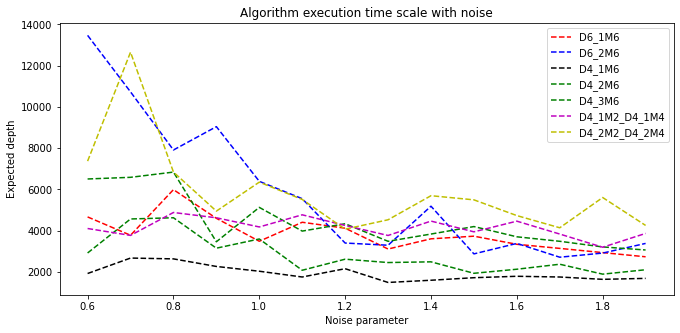

In [13]:
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(11)
ax.set_ylabel('Expected depth')
ax.set_xlabel('Noise parameter')
ax.set_title('Algorithm execution time scale with noise')

plt.plot(noise_consts, ress_D6_1M6, 'r--', label='D6_1M6')
plt.plot(noise_consts, ress_D6_2M6, 'b--', label='D6_2M6')
plt.plot(noise_consts, ress_D4_1M6, 'k--', label='D4_1M6')
plt.plot(noise_consts, ress_D4_2M6, 'g--', label='D4_2M6')
plt.plot(noise_consts, ress_D4_3M6, 'g--', label='D4_3M6')
plt.plot(noise_consts, ress_D4_1M2_D4_1M4, 'm--', label='D4_1M2_D4_1M4')
plt.plot(noise_consts, ress_D4_2M2_D4_2M4, 'y--', label='D4_2M2_D4_2M4')
plt.legend()
plt.savefig('images/6_qubit_tests_.png')
plt.show()

In [32]:
# tests on 8qubits
testers = []
noise_consts = list([x/5 for x in range(3, 10)])
for i in noise_consts:
    noise_constant = i
    NM = NoiseModels(noise_constant)
    noise_model = NM.initialize_thermal_noise()
    backend = QasmSimulator(method='density_matrix',
                                noise_model=noise_model)
    execution_params = (coupling_map, basis_gates, noise_model)
    testers+=[OtherCases(backend, execution_params)]

Len = len(testers)

ress_D8_1M8 = test_experiment_expected_depth((lambda test_class: testies._D8_iM8(test_class, 1)))
ress_D8_2M8 = test_experiment_expected_depth((lambda test_class: testies._D8_iM8(test_class, 2)))

ress_D6_1M8 = test_experiment_expected_depth((lambda test_class: testies._D6_iM8(test_class, 1)))
ress_D6_2M8 = test_experiment_expected_depth((lambda test_class: testies._D6_iM8(test_class, 2)))

ress_G1D6_1M8 = test_experiment_expected_depth((lambda test_class: testies._G1D6_iM8(test_class, 1)))
ress_G1D6_2M8 = test_experiment_expected_depth((lambda test_class: testies._G1D6_iM8(test_class, 2)))

ress_G1D7_1M8 = test_experiment_expected_depth((lambda test_class: testies._G1D7_iM8(test_class, 1)))
ress_G1D7_2M8 = test_experiment_expected_depth((lambda test_class: testies._G1D7_iM8(test_class, 2)))

# to other category
ress_G2D6_1M8 = test_experiment_expected_depth((lambda test_class: testies._G2D6_iM8(test_class, 1)))
ress_G2D6_2M8 = test_experiment_expected_depth((lambda test_class: testies._G2D6_iM8(test_class, 2)))

NOISE CONSTANT: 0.6
Test D8_1M8: __________________
NOISE CONSTANT: 0.8
Test D8_1M8: __________________
NOISE CONSTANT: 1.0
Test D8_1M8: __________________
NOISE CONSTANT: 1.2
Test D8_1M8: __________________
NOISE CONSTANT: 1.4
Test D8_1M8: __________________
NOISE CONSTANT: 1.6
Test D8_1M8: __________________
NOISE CONSTANT: 1.8
Test D8_1M8: __________________
NOISE CONSTANT: 0.6
Test D8_2M8: __________________
NOISE CONSTANT: 0.8
Test D8_2M8: __________________
NOISE CONSTANT: 1.0
Test D8_2M8: __________________
NOISE CONSTANT: 1.2
Test D8_2M8: __________________
NOISE CONSTANT: 1.4
Test D8_2M8: __________________
NOISE CONSTANT: 1.6
Test D8_2M8: __________________
NOISE CONSTANT: 1.8
Test D8_2M8: __________________
NOISE CONSTANT: 0.6
Test D6_1M8: __________________
NOISE CONSTANT: 0.8
Test D6_1M8: __________________
NOISE CONSTANT: 1.0
Test D6_1M8: __________________
NOISE CONSTANT: 1.2
Test D6_1M8: __________________
NOISE CONSTANT: 1.4
Test D6_1M8: __________________
NOISE CONSTA

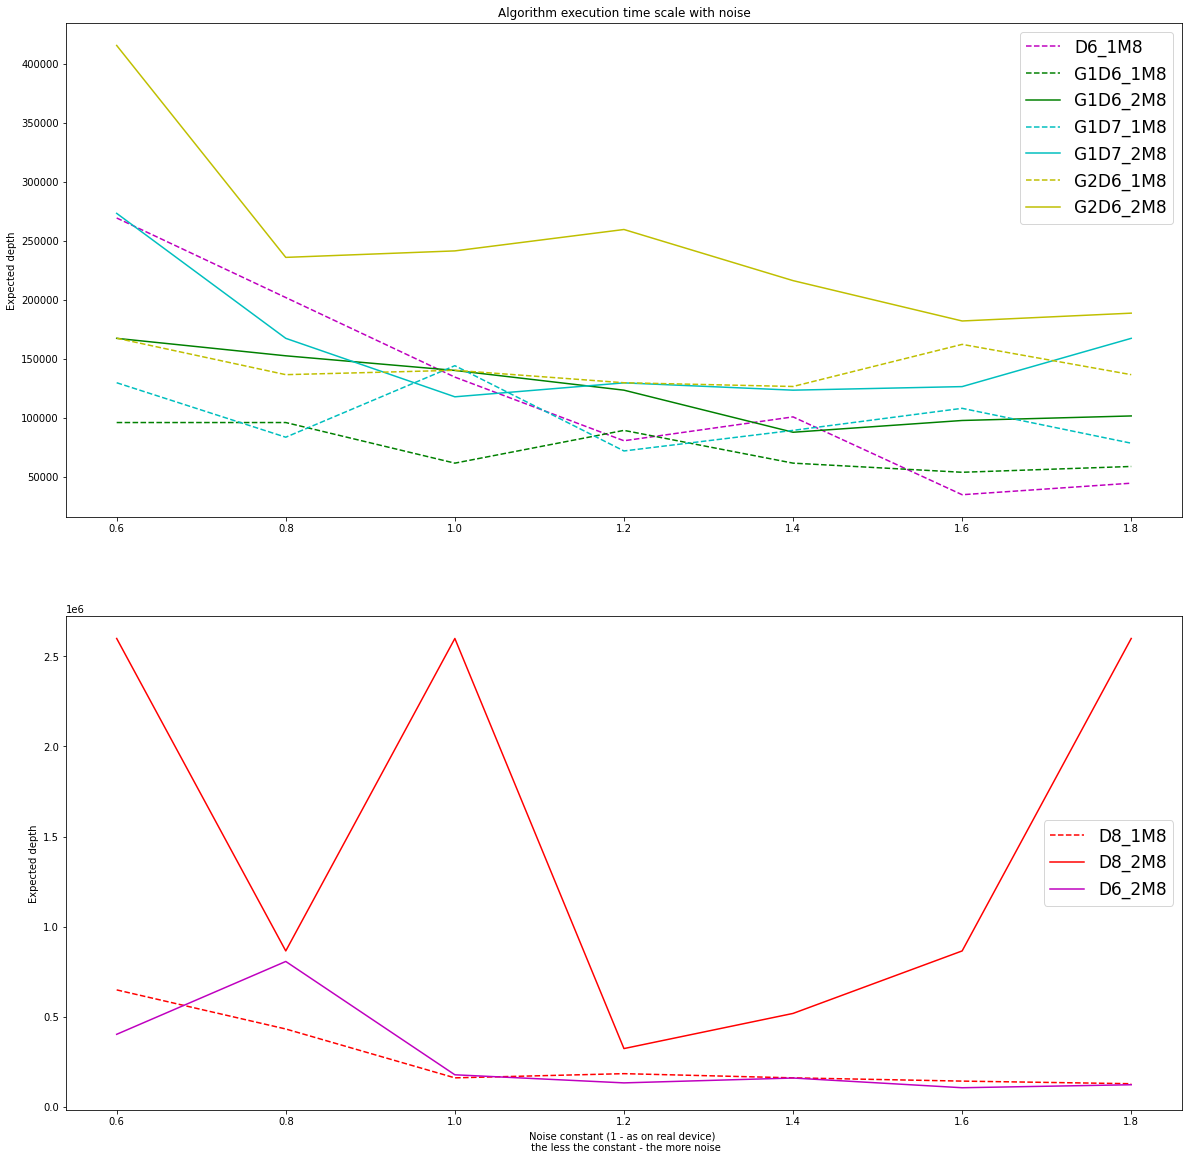

In [81]:
# fig, ax = plt.subplots(2)
# plt.figure(figsize=(6, 6))
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
ax = [None, None]
# Adds subplot on position 1
ax[0] = fig.add_subplot(211)
# Adds subplot on position 2
ax[1] = fig.add_subplot(212, sharex = ax[0])

ax[0].set_ylabel('Expected depth')
ax[1].set_ylabel('Expected depth')
ax[1].set_xlabel('Noise constant (1 - as on real device) \n the less the constant - the more noise')
ax[0].set_title('Algorithm execution time scale with noise')

# some numbers are too big, so it would be convenient to show them on another graph 

ax[1].plot(noise_consts, ress_D8_1M8, 'r--', label='D8_1M8')
ax[1].plot(noise_consts, ress_D8_2M8, 'r', label='D8_2M8')

ax[0].plot(noise_consts, ress_D6_1M8, 'm--', label='D6_1M8')
ax[1].plot(noise_consts, ress_D6_2M8, 'm', label='D6_2M8')

ax[0].plot(noise_consts, ress_G1D6_1M8, 'g--', label='G1D6_1M8')
ax[0].plot(noise_consts, ress_G1D6_2M8, 'g', label='G1D6_2M8')

ax[0].plot(noise_consts, ress_G1D7_1M8, 'c--', label='G1D7_1M8')
ax[0].plot(noise_consts, ress_G1D7_2M8, 'c', label='G1D7_2M8')

ax[0].plot(noise_consts, ress_G2D6_1M8, 'y--', label='G2D6_1M8')
ax[0].plot(noise_consts, ress_G2D6_2M8, 'y', label='G2D6_2M8')

ax[0].legend(prop={'size': 17})
ax[1].legend(prop={'size': 17})
plt.show()

In [6]:
# tests on 10 qubits
# depends on the processor it could take about 14:06
testers = []
noise_consts = list([x/5 for x in range(3, 10)])
for i in noise_consts:
    noise_constant = i
    NM = NoiseModels(noise_constant)
    noise_model = NM.initialize_thermal_noise()
    backend = QasmSimulator(method='density_matrix',
                                noise_model=noise_model)
    execution_params = (coupling_map, basis_gates, noise_model)
    testers+=[OtherCases(backend, execution_params)]

Len = len(testers)

ress_D10_1M10 = test_experiment_expected_depth((lambda test_class: testies._D10_iM10(test_class, 1)))
ress_D10_2M10 = test_experiment_expected_depth((lambda test_class: testies._D10_iM10(test_class, 2)))

ress_D8_1M10 = test_experiment_expected_depth((lambda test_class: testies._D8_iM10(test_class, 1)))
ress_D8_2M10 = test_experiment_expected_depth((lambda test_class: testies._D8_iM10(test_class, 2)))


NOISE CONSTANT: 0.6
Test D10_1M10: __________________


KeyboardInterrupt: 

In [1]:
fig, ax = plt.subplots()
ax.set_ylabel('Expected depth')
ax.set_xlabel('Noise constant (1 - as on real device) \n the less the constant - the more noise')
ax.set_title('Algorithm execution time scale with noise')

plt.plot(noise_consts, ress_D10_1M10, 'r--', label='D10_1M10')
plt.plot(noise_consts, ress_D10_2M10, 'r', label='D10_2M10')
plt.plot(noise_consts, ress_D8_1M10, 'g--', label='D8_1M10')
plt.plot(noise_consts, ress_D8_2M10, 'g', label='D8_2M10')


# here algotithms could have P-actual = 0
# if so happens you will see an error 
# that means that these experiments are no better than noise
plt.legend()
plt.show()

NameError: name 'plt' is not defined

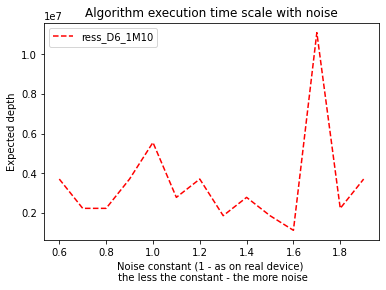

In [35]:
fig, ax = plt.subplots()
ax.set_ylabel('Expected depth')
ax.set_xlabel('Noise constant (1 - as on real device) \n the less the constant - the more noise')
ax.set_title('Algorithm execution time scale with noise')

plt.plot(noise_consts, ress_D6_1M10, 'r--', label='ress_D6_1M10')

plt.legend()
plt.show()

In [5]:
# Now we will conduct a set of experiments to find an aproximate noise constant for thermal noise model
# to have feasible probabilities on 10 qubit tests
testers = []
# noise_consts = list([x/5 for x in range(3, 10)])
noise_consts = [100]
for i in noise_consts:
    noise_constant = i
    NM = NoiseModels(noise_constant)
    noise_model = NM.initialize_thermal_noise()
    backend = QasmSimulator(method='density_matrix',
                                noise_model=noise_model)
    execution_params = (coupling_map, basis_gates, noise_model)
    testers+=[OtherCases(backend, execution_params)]

Len = len(testers)

# ress_D8_1M10 = test_experiment_expected_depth((lambda test_class: testies._D8_iM10(test_class, 1)))
# ress_D8_2M10 = test_experiment_expected_depth((lambda test_class: testies._D8_iM10(test_class, 2)))
# ress_D8_3M10 = test_experiment_expected_depth((lambda test_class: testies._D8_iM10(test_class, 3)))
full_ress_D8_1M10 = test_experiment((lambda test_class: testies._D8_iM10(test_class, 1)))
full_ress_D8_2M10 = test_experiment((lambda test_class: testies._D8_iM10(test_class, 2)))
full_ress_D8_3M10 = test_experiment((lambda test_class: testies._D8_iM10(test_class, 3)))
full_ress_D8_4M10 = test_experiment((lambda test_class: testies._D8_iM10(test_class, 4)))
full_ress_D8_5M10 = test_experiment((lambda test_class: testies._D8_iM10(test_class, 5)))

NOISE CONSTANT: 100
Test D8_1M10: __________________
NOISE CONSTANT: 100
Test D8_2M10: __________________
NOISE CONSTANT: 100
Test D8_3M10: __________________
NOISE CONSTANT: 100
Test D8_4M10: __________________
NOISE CONSTANT: 100
Test D8_5M10: __________________


In [6]:
print(full_ress_D8_1M10)
print(full_ress_D8_2M10)
print(full_ress_D8_3M10)
print(full_ress_D8_4M10)
print(full_ress_D8_5M10)

[[0.008697748184203899, 0.007568359375, 2.8181818181818183, 3190, 0.8701515857569897, 421491.6129032258]]
[[0.02365943050244733, 0.023681640625, 8.818181818181818, 6378, 1.0009387429063592, 269322.55670103093]]
[[0.04493015706431193, 0.037353515625, 13.909090909090908, 9566, 0.8313684630911281, 256093.69934640522]]
[[0.071185700508158, 0.055908203125, 20.818181818181817, 12754, 0.7853853052776073, 228123.9475982533]]
[[0.10079149941353115, 0.080810546875, 30.09090909090909, 15942, 0.8017595466404112, 197276.22960725075]]


In [25]:
print(full_ress_D8_3M10)

[[0.04493015706431193, 0.00244140625, 0.7142857142857143, 9566, 0.05433780804517177, 3918233.6], [0.04493015706431193, 0.0078125, 2.4615384615384617, 9566, 0.17388098574454966, 1224448.0], [0.04493015706431193, 0.026611328125, 8.384615384615385, 9566, 0.5922821076923723, 359470.97247706424], [0.04493015706431193, 0.033935546875, 11.583333333333334, 9566, 0.7552955318278876, 281887.309352518], [0.04493015706431193, 0.042724609375, 15.909090909090908, 9566, 0.9509116407905059, 223899.06285714285], [0.04493015706431193, 0.044921875, 14.153846153846153, 9566, 0.9998156680311606, 212947.47826086957]]


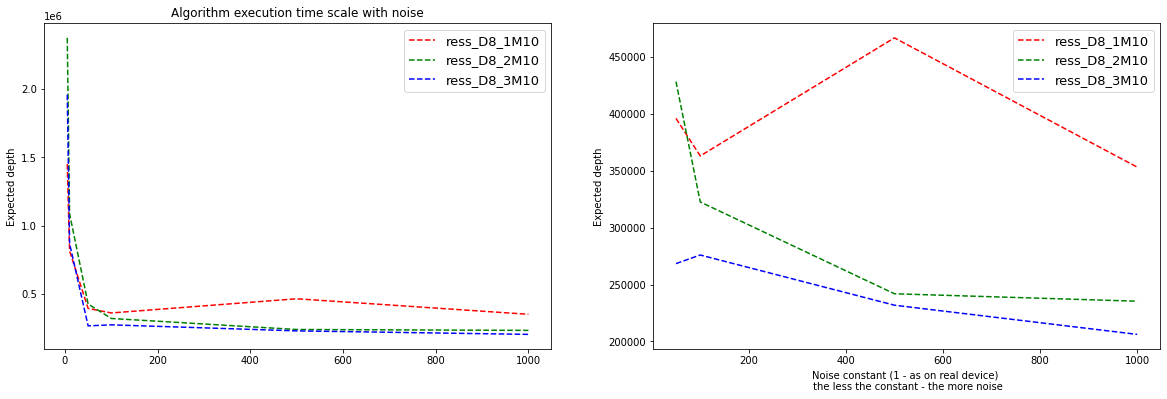

In [26]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(20)
ax = [None, None]
# Adds subplot on position 1
ax[0] = fig.add_subplot(121)
# Adds subplot on position 2
ax[1] = fig.add_subplot(122)

ax[0].set_ylabel('Expected depth')
ax[1].set_ylabel('Expected depth')
ax[1].set_xlabel('Noise constant (1 - as on real device) \n the less the constant - the more noise')
ax[0].set_title('Algorithm execution time scale with noise')

# some numbers are too big, so it would be convenient to show them on another graph 
ax[0].plot(noise_consts, ress_D8_1M10, 'r--', label='ress_D8_1M10')
ax[0].plot(noise_consts, ress_D8_2M10, 'g--', label='ress_D8_2M10')
ax[0].plot(noise_consts, ress_D8_3M10, 'b--', label='ress_D8_3M10')

ax[1].plot(noise_consts[2:], ress_D8_1M10[2:], 'r--', label='ress_D8_1M10')
ax[1].plot(noise_consts[2:], ress_D8_2M10[2:], 'g--', label='ress_D8_2M10')
ax[1].plot(noise_consts[2:], ress_D8_3M10[2:], 'b--', label='ress_D8_3M10')

ax[0].legend(prop={'size': 13})
ax[1].legend(prop={'size': 13})
plt.show()

In [ ]:
# now we can see tha P_theoretical is quite low 

In [7]:
testers = []
# noise_consts = list([x/5 for x in range(3, 10)])
noise_consts = [100]
for i in noise_consts:
    noise_constant = i
    NM = NoiseModels(noise_constant)
    noise_model = NM.initialize_thermal_noise()
    backend = QasmSimulator(method='density_matrix',
                                noise_model=noise_model)
    execution_params = (coupling_map, basis_gates, noise_model)
    testers+=[OtherCases(backend, execution_params)]

Len = len(testers)

full_ress_D10_1M10 = test_experiment((lambda test_class: testies._D10_iM10(test_class, 1)))
full_ress_D10_2M10 = test_experiment((lambda test_class: testies._D10_iM10(test_class, 2)))
full_ress_D10_3M10 = test_experiment((lambda test_class: testies._D10_iM10(test_class, 3)))
full_ress_D10_4M10 = test_experiment((lambda test_class: testies._D10_iM10(test_class, 4)))
full_ress_D10_5M10 = test_experiment((lambda test_class: testies._D10_iM10(test_class, 5)))

NOISE CONSTANT: 100
Test D10_1M10: __________________
NOISE CONSTANT: 100
Test D10_2M10: __________________
NOISE CONSTANT: 100
Test D10_3M10: __________________
NOISE CONSTANT: 100
Test D10_4M10: __________________
NOISE CONSTANT: 100
Test D10_5M10: __________________


In [8]:
print(full_ress_D10_1M10)
print(full_ress_D10_2M10)
print(full_ress_D10_3M10)
print(full_ress_D10_4M10)
print(full_ress_D10_5M10)

[[0.008766189217567047, 0.00927734375, 3.4545454545454546, 5110, 1.0583097763174703, 550804.2105263158]]
[[0.024223848595509564, 0.0166015625, 6.181818181818182, 10218, 0.6853395914585378, 615484.2352941176]]
[[0.04710825057121048, 0.034912109375, 14.3, 15326, 0.7411039245073564, 438988.0839160839]]
[[0.07706217555206066, 0.055908203125, 19.083333333333332, 20434, 0.7254947414147459, 365491.9825327511]]
[[0.11361805052085808, 0.072265625, 24.666666666666668, 25542, 0.6360400012912862, 353446.0540540541]]


In [28]:
def full_result_to_expected_depth(result):
    new_res = []
    for i in range(len(result)):
        new_res += [result[i][5]]
    return new_res


In [33]:
print(full_ress_D10_3M10)
print(full_ress_D10_3M10)

[[0.04710825057121048, 0.001708984375, 0.4375, 15326, 0.03627781448637409, 8967899.42857143], [0.04710825057121048, 0.001708984375, 0.5833333333333334, 15326, 0.03627781448637409, 8967899.42857143], [0.04710825057121048, 0.029541015625, 10.083333333333334, 15326, 0.6270879361216093, 518804.0991735537], [0.04710825057121048, 0.03466796875, 12.909090909090908, 15326, 0.7359213795807316, 442079.54929577466], [0.04710825057121048, 0.03759765625, 11.846153846153847, 15326, 0.79811191870023, 407631.7922077922], [0.04710825057121048, 0.044189453125, 15.083333333333334, 15326, 0.9380406317191015, 346824.8397790055]]


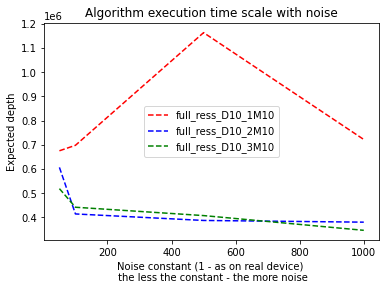

In [32]:
fig, ax = plt.subplots()
ax.set_ylabel('Expected depth')
ax.set_xlabel('Noise constant (1 - as on real device) \n the less the constant - the more noise')
ax.set_title('Algorithm execution time scale with noise')

plt.plot(noise_consts[2:], full_result_to_expected_depth(full_ress_D10_1M10[2:]), 'r--', label='full_ress_D10_1M10')
plt.plot(noise_consts[2:], full_result_to_expected_depth(full_ress_D10_2M10[2:]), 'b--', label='full_ress_D10_2M10')
plt.plot(noise_consts[2:], full_result_to_expected_depth(full_ress_D10_3M10[2:]), 'g--', label='full_ress_D10_3M10')
plt.legend()
plt.show()

In [ ]:
# Simple three qubit tests to run
# If you want this feature you should probably turn on VPN before executing this line
# it is not necessary to run this for tests

provider = IBMQ.load_account()

In [ ]:
back = provider.get_backend("ibmq_quito")
simulator = Aer.get_backend('qasm_simulator').from_backend(back)

In [ ]:
# for this you need to load IBMQ account as provider
# first tests. Make sure you can successfully run those 
test = ThreeQubitCases(back, simulator)
test.D2M3()
test.D3M3()
test.D3D3M3()
test.D2M1_D2M2()
test.G1D2M2()